In [162]:
from alns import ALNS
from alns.accept import RecordToRecordTravel, SimulatedAnnealing
from alns.select import RouletteWheel
from alns.stop import MaxRuntime
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np

from instancia import crear_grafo_inicial
from solvers_listos import (simular_demanda_diaria)

from funciones import (
    read_data,
    calcular_distancia,
    calcular_matriz_dist,
    calcular_largo_ruta,
    graficar_ruta,
)

random.seed(42)
np.random.seed(42)

In [163]:
def simular_demanda_diaria(data, dist="d", log=False):
    demanda = {}
    demanda['N_0'] = 0
    for i in range(1, len(data)):
        if dist == "p":
            demanda[f'N_{i}'] = int(round(np.random.poisson(data[i]), 0))
        elif dist == "n":
            demanda[f'N_{i}'] = int(round(np.random.normal(data[i], data[i] / 10), 0))
        elif dist == "u":
            demanda[f'N_{i}'] = int(round(np.random.uniform(data[i] / 2, data[i] * 1.5), 0))
        elif dist == "d":
            demanda[f'N_{i}'] = int(round(data[i], 0))

    if log:
        print("Demanda del día: ", demanda)
        # print(i, ":", data[i])
    return demanda

In [164]:
# Cargar datos
G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo= 'IRP3.xlsx' ,plot=False)
matriz_dst = calcular_matriz_dist_alns(G)
demandas = simular_demanda_diaria(list(info_locales["r"]), dist="n")
# for nodo in G.nodes(data=True):
#     # print(nodo)
#     print(demandas[int(nodo[0][2:])])
print(demandas)

{'N_0': 0, 'N_1': 42, 'N_2': 24, 'N_3': 64, 'N_4': 89, 'N_5': 61, 'N_6': 40, 'N_7': 74, 'N_8': 60, 'N_9': 15, 'N_10': 38, 'N_11': 42, 'N_12': 93, 'N_13': 44, 'N_14': 34, 'N_15': 29, 'N_16': 52, 'N_17': 71, 'N_18': 85, 'N_19': 42, 'N_20': 21, 'N_21': 56, 'N_22': 18, 'N_23': 32, 'N_24': 55, 'N_25': 45, 'N_26': 28, 'N_27': 12, 'N_28': 38, 'N_29': 92, 'N_30': 93}


In [165]:
class IRPState:
    """
    Estado de solución del IRP
    """

    def __init__(self, routes, unnasigned=None, matriz_dst = matriz_dst):
        self.routes = routes  # será solo una ruta ya que es solo un vehículo
        self.unnasigned = unnasigned if unnasigned is not None else []

    def copy(self):
        return IRPState(self.routes.copy(), self.unnasigned.copy())

    def objective(self):
        ruta = self.routes[0][:]
        ruta = [int(x.split("_")[-1]) for x in ruta]
        return calcular_largo_ruta(ruta, matriz_dst)

    @property
    def cost(self):
        return self.objective()

    def find_route(self, node):
        for route in self.routes:
            if node in route:
                return route

In [166]:
degree_of_destruction = 0.1
nodes_to_destroy = int(np.ceil(degree_of_destruction * len(G.nodes)))
nodes_to_destroy

4

In [167]:
def random_removal(state, random_state):
    destroyed = state.copy()

    for node in random_state.choice(
        range(1, len(G.nodes)), nodes_to_destroy, replace=False
    ):
        node = f"N_{node}"
        if node == "N_0":
            print("No se puede eliminar el depósito")
        destroyed.unnasigned.append(node)
        route = destroyed.find_route(node)
        if route is not None:
            route.remove(node)
    
    non_empty_routes = [ruta for ruta in destroyed.routes if len(ruta) > 0]

    destroyed.routes = non_empty_routes
    return destroyed

def greedy_repair(state, random_state):
    repaired = state.copy()

    random_state.shuffle(repaired.unnasigned)

    while len(repaired.unnasigned) > 0:
        node = repaired.unnasigned.pop()
        route, idx = best_insert(node, repaired)
        if route is not None:
            route.insert(idx, node)
        else:
            repaired.routes.append([node])

    return repaired

def best_insert(node, state):
    best_cost, best_route, best_idx = float("inf"), None, None

    for route in state.routes:
        for i in range(1, len(route) + 1):
            if can_insert(node, route):
                cost = insertion_cost(node, route, i)

                if cost < best_cost:
                    best_cost = cost
                    best_route = route
                    best_idx = i

    return best_route, best_idx

def can_insert(node, route, demanda=demandas):
    total = sum([demanda[nodo] for nodo in route])
    return total + demanda[node] <= cap_tpte

def insertion_cost(node, route, idx):
    pred = "N_0" if idx == 0 else route[idx - 1]
    succ = "N_0" if idx == len(route) else route[idx]
    pred = int(pred.split("_")[-1])
    succ = int(succ.split("_")[-1])
    node = int(node.split("_")[-1])
    dist = matriz_dst[pred][node] + matriz_dst[node][succ] - matriz_dst[pred][succ]
    return dist

def calcular_matriz_dist_alns(G):
    matriz_distancias = {int(nodo[2:]): {} for nodo in G.nodes()}
    for arco in G.edges(data=True):
        n1, n2, data = arco
        n1 = int(n1.split("_")[-1])
        n2 = int(n2.split("_")[-1])
        matriz_distancias[n1][n2] = data['weight']

    for n1 in G.nodes():
        n1 = int(n1.split("_")[-1])
        for n2 in G.nodes():
            n2 = int(n2.split("_")[-1])
            if n2 not in matriz_distancias[n1].keys():
                matriz_distancias[n1][n2] = np.inf
    return matriz_distancias

In [175]:
def neighborhood(G, node, distancias = matriz_dst, cap_tpte = np.inf):
    # ordenaremos los nodo por distancia al nodo actual
    
    return sorted(G.neighbors(node), key=lambda x: distancias[int(node[2:])][int(x[2:])])

cap_tpte = 1000
def nearest_neighbor_adapted(G, demandas):
    """
    Adaptación del algoritmo Nearest Neighbor descrito anteriormente para que se utilice con la
    clase IRPState
    """
    G0 = G.copy()
    routes = []
    available = list(G.nodes)
    available.remove("N_0")
    route = ["N_0"]  # siempre empezamos en el nodo 0
    route_demands = 0
    distancias = calcular_matriz_dist_alns(G0)

    while available:
        current = route[-1]

        my_neighbors = neighborhood(G0, current, distancias=distancias)
        while my_neighbors[0] in route:
            my_neighbors = my_neighbors[1:]
        nearest = my_neighbors[0]

        if route_demands + demandas[nearest] <= cap_tpte:
            route.append(nearest)
            route_demands += demandas[nearest]
            # print('nodesd:', nodes, 'nearest:', nearest)
            available.remove(nearest)
        else:
            break
    routes.append(route)

    return IRPState(routes)

# irp_NN = nearest_neighbor_adapted(G, demandas)
# print(irp_NN.routes)

[['N_0', 'N_24', 'N_20', 'N_3', 'N_11', 'N_28', 'N_30', 'N_15', 'N_17', 'N_6', 'N_25', 'N_19', 'N_14', 'N_8', 'N_9', 'N_2', 'N_21', 'N_29', 'N_4', 'N_13', 'N_22']]


In [169]:
def simple_forecaster(x):
    # recive el diccionario de demanda y devuelve un diccionario con una demanda levemente modificada
    for key in x.keys():
        noise = np.random.normal(0, 5)
        x[key] = int(round(x[key] + noise, 0))

iniciando...
Best heuristic objective is 1511.9516926504905.
Route 0: ['N_0', 'N_10', 'N_7', 'N_23', 'N_17', 'N_6', 'N_25', 'N_19', 'N_16', 'N_14', 'N_8', 'N_9', 'N_2', 'N_5', 'N_20', 'N_26', 'N_1', 'N_0']


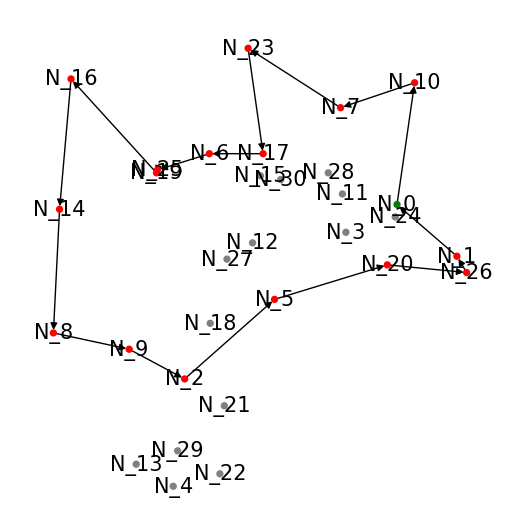

In [182]:
T = 10  # periodos
V = 10  # vertices


def proactive_routing_only(G, demandas, T=1):
    print("iniciando...")
    init = nearest_neighbor_adapted(G, demandas)
    for t in range(T):
        # print(init.routes)
        # for i in range(1, len(init.routes[t-1])):   # QUIZAS EST'E AFECTANDO NO MODIFICAR LAS DEMANDAS
        # d = simple_forecaster(x)
        #    pass

        alns = ALNS(np.random.RandomState(42))
        alns.add_destroy_operator(random_removal)
        alns.add_repair_operator(greedy_repair)

        select = RouletteWheel([10, 5, 2, 0], 0.7, 1, 1)
        # accept = RecordToRecordTravel.autofit(init.objective(), 0.02, 0, 9000)
        accept = SimulatedAnnealing(
            start_temperature=20000,
            end_temperature=0.1,
            step=0.9993,
            method="exponential",
        )
        stop = MaxRuntime(5)

        result = alns.iterate(init, select, accept, stop)
        init = result.best_state

    return result

result = proactive_routing_only(G, demandas, T=2)
solution = result.best_state
objective = solution.objective()
# pct_diff = 100 * (objective - bks.cost) / bks.cost

print(f"Best heuristic objective is {objective}.")
for idx, route in enumerate(solution.routes):
    print(f"Route {idx}:", route + ['N_0'])
    graficar_ruta(G= G, ruta= route + ['N_0'])